# Intro
In this chapter, we will cover the instruction fine-tuning process of LLMs.

Below you see the general outline of the entire repo since this is the last chapter. Hence, you may see the big picture at last.

Here is an outline of the chapter.


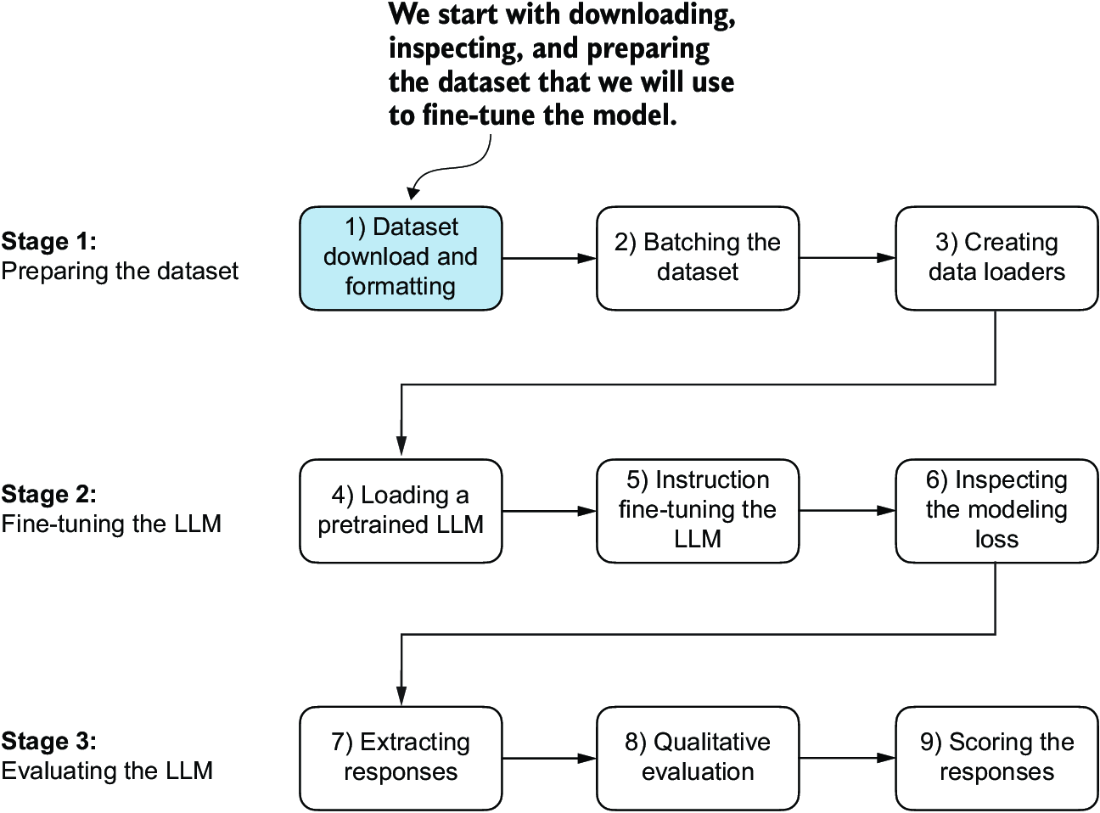

In [25]:
from IPython.display import Image
from tensorflow.python.training.input import shuffle_batch
from termcolor import colored
from werkzeug.http import generate_etag

print(colored("Here is an outline of the chapter.", "green", attrs=["bold"]))
Image("images/outline of the chapter.png", width=640*1.2, height=480*1.2)

Here, we focus on improving the LLM’s ability to follow such instructions and generate a desired response, as illustrated below.


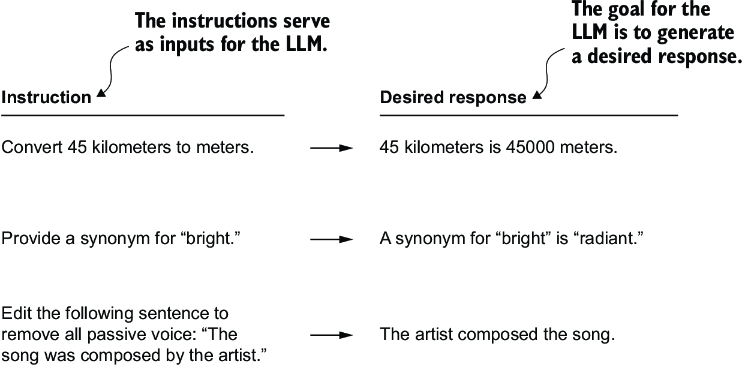

In [23]:
print(colored(
    text="Here, we focus on improving the LLM’s ability to follow such instructions and generate a desired response, as illustrated below.",
    color="light_green",
    on_color=None,
    attrs=["bold"]))
Image("images/instruction-response pairs.png", width=640*0.9, height=480*0.9)

### Instruction Dataset

In [28]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    "This function downloads a file and then loads it into the current working directory."
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r") as file:
        data = json.load(file)

    return data

In [29]:
file_path = "instruction_data.json"
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json")

data = download_and_load_file(file_path, url)
print("Number of entires:", len(data))

Number of entires: 1100


In [30]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [34]:
print("Example entry:\n", data[999])
print("\n", colored(
    text="As you can see, the structure of the data is 'instruction', 'input' and 'output'. The 'input' field may be empty.",
    color="light_green",
    attrs=["bold"]
))

Example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}

 As you can see, the structure of the data is 'instruction', 'input' and 'output'. The 'input' field may be empty.


In [37]:
def format_input(entry):
    """This function takes the data and converts it int a alpaca style prompt. This takes a dictionary entry as input and constructs a formatted string."""
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [40]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


**Let's see if the format_input function will skip the "Input" part of the prompt if it is empty;**

In [41]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


**Yes it did**

Let's split the data into train, test, validation sets.

In [42]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Batching the Data

The batching process for instruction fine-tuning is a bit more involved and requires us to create our own custom collate function that we will later plug into the `DataLoader`.

In [43]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [44]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


#### Important information
We adopt a more sophisticated approach by developing a custom collate function that we can pass to the data loader. This custom collate function pads the training examples in each batch to the same length while allowing different batches to have different lengths. This approach minimizes unnecessary padding by only extending sequences to **match the longest one in each batch, not the whole dataset.**

I am writing this explanation again since it is important to understand the logic behind our own collate function.
This approach minimizes unnecessary padding by only extending sequences to match the longest one in each batch, not the whole dataset


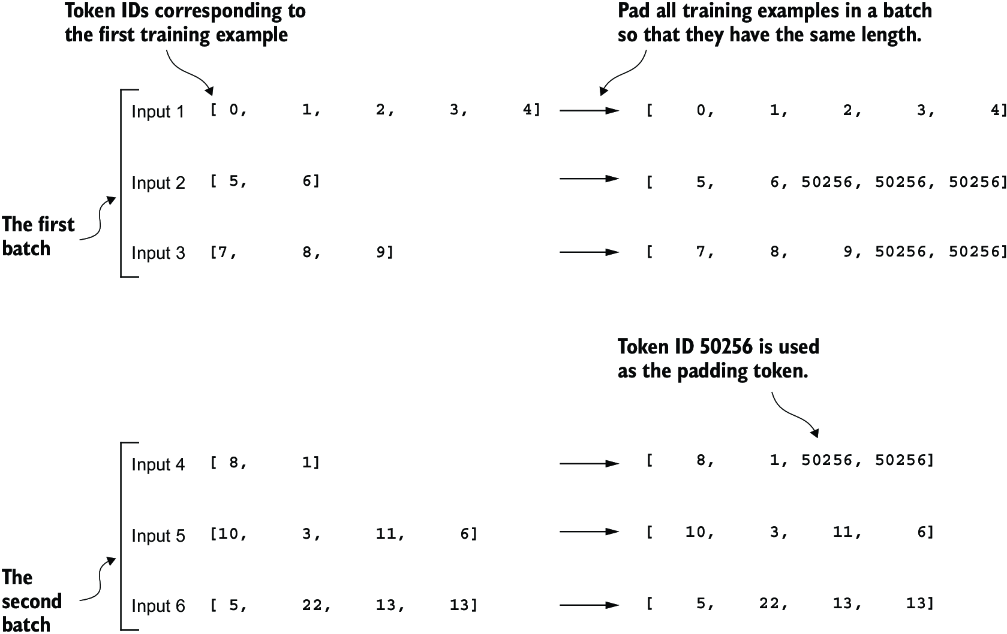

In [71]:
print(f"""I am writing this explanation again since it is important to understand the logic behind our own collate function.
{colored(
    text='This approach minimizes unnecessary padding by only extending sequences to match the longest one in each batch, not the whole dataset',color='light_green',
    attrs=['bold'],
    on_color='on_grey')}""")
Image("images/custom collate function.png", width=640, height=480)

**Let's implement our own collate function;**

In [69]:
def custom_collate_draft_1(
        batch,
        pad_token_id=50256,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_1st = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_1st.append(inputs)

    inputs_tensor = torch.stack(inputs_1st).to(device)
    return inputs_tensor

In [70]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (inputs_1, inputs_2, inputs_3)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


We always add an end-of-text (padding) token to the target


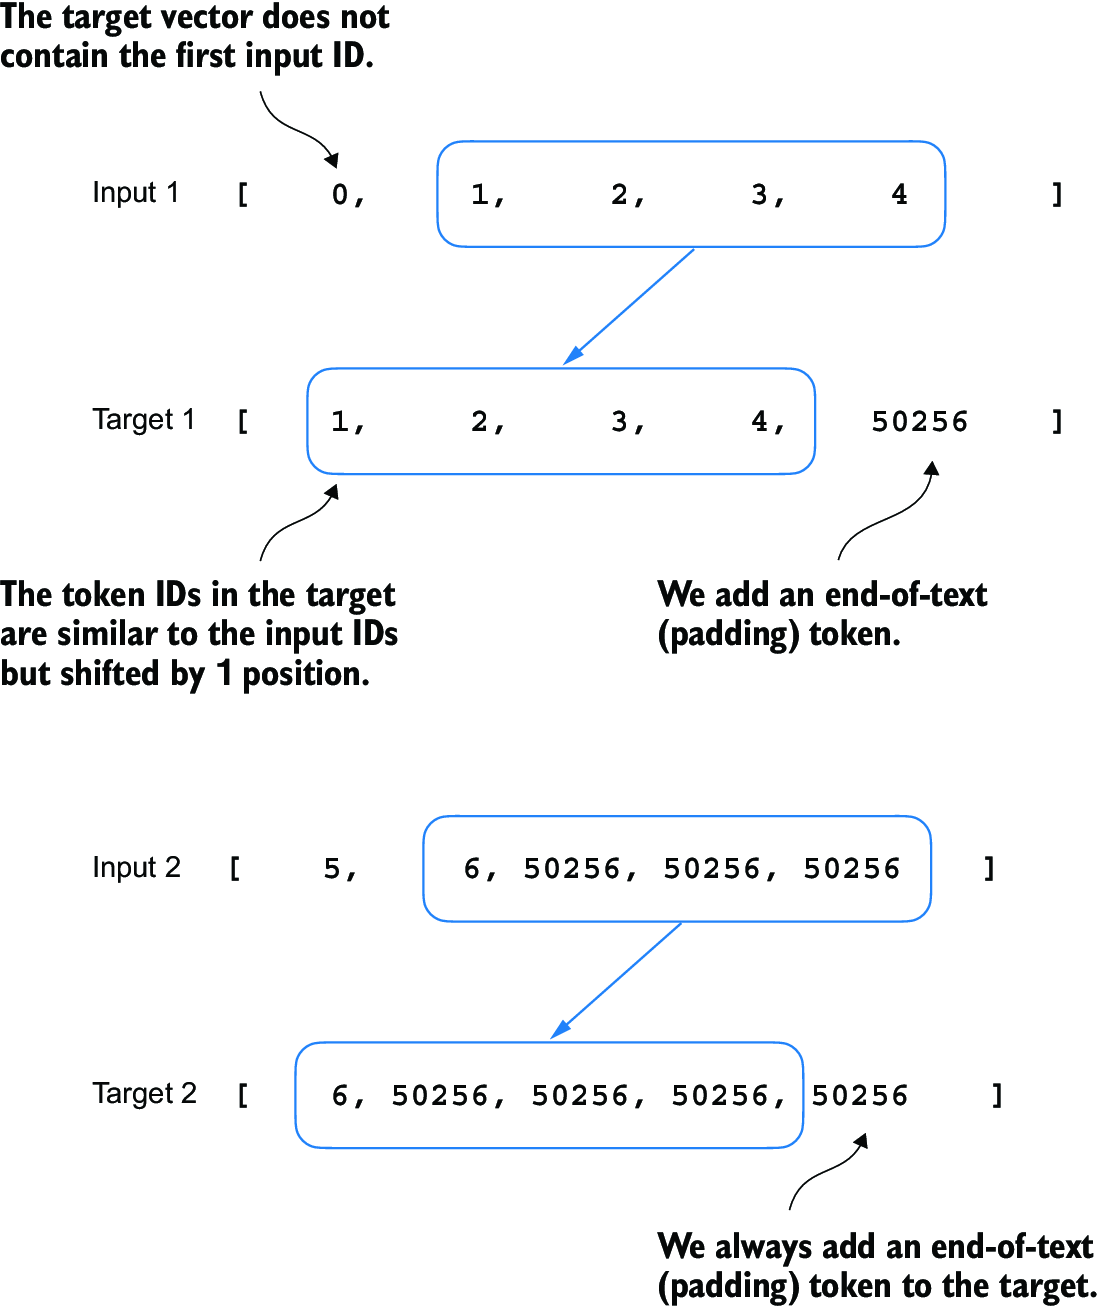

In [84]:
print(colored(
    text="We always add an end-of-text (padding) token to the target",
    color="light_green",
    attrs=['bold']
))
Image("images/target token.png", width=640*1.3, height=480*1.3)

In [85]:
def custom_collate_draft_2(
        batch,
        pad_token_id=50256,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_1st, targets_1st = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_1st.append(inputs)
        targets_1st.append(targets)

    inputs_tensor = torch.stack(inputs_1st).to(device)
    targets_tensor = torch.stack(targets_1st).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)

print("inputs:\n", inputs)
print("\ntargets:\n",targets)

inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


**In the next step, we assign a -100 placeholder value to all padding tokens. This special value allows us to exclude these padding tokens from contributing to the training loss calculation, ensuring that only meaningful data influences model learning.**

**We retain one end-of-text token, ID 50256, in the target list. Retaining it allows the LLM to learn when to generate an end-of-text token in response to instructions.**

In the following listing, we modify our custom collate function to replace tokens with ID 50256 with -100 in the target lists. Additionally, we introduce an allowed_ max_length parameter to optionally limit the length of the samples.

In [86]:
def custom_collate_fn(
        batch,
        pad_token_id=50256,
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_1st, targets_1st = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item +  [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets==pad_token_id
        indices = torch.nonzero(mask).squeeze()

        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_1st.append(inputs)
        targets_1st.append(targets)

    inputs_tensor = torch.stack(inputs_1st).to(device)
    targets_tensor = torch.stack(targets_1st).to(device)
    return inputs_tensor, targets_tensor

In [87]:
inputs, targets = custom_collate_fn(batch)
print("inputs:\n", inputs)
print("\ntargets:\n",targets)

inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [88]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5]]
)
targets_1 = torch.tensor([0, 1]) #Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print("loss:\n", loss_1)

loss:
 tensor(1.1269)


In [89]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print("loss:\n", loss_2)

loss:
 tensor(0.7936)


In [90]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print("loss:\n", loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

loss:
 tensor(1.1269)
loss_1 == loss_3: tensor(True)


The cross entropy loss function ignored the third entry in the targets_3 vector, the token ID corresponding to -100.

**So what’s so special about -100 that it’s ignored by the cross entropy loss? The default setting of the cross entropy function in PyTorch is cross_entropy(..., ignore_index=-100). This means that it ignores targets labeled with -100. We take advantage of this ignore_index to ignore the additional end-of-text (padding) tokens that we used to pad the training examples to have the same length in each batch. However, we want to keep one 50256 (end-of-text) token ID in the targets because it helps the LLM to learn to generate end-of-text tokens, which we can use as an indicator that a response is complete.**

### Data Loaders

In [91]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: mps:0


In [92]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [96]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers # When fetching from iterable-style datasets with multi-processing, the drop_last argument drops the last non-full batch of each worker’s dataset replica.
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [101]:
print("Train loader:")
for inputs, targets in train_loader:
    print(f"inputs shape: {inputs.shape}, targets shape: {targets.shape}")

Train loader:
inputs shape: torch.Size([8, 68]), targets shape: torch.Size([8, 68])
inputs shape: torch.Size([8, 67]), targets shape: torch.Size([8, 67])
inputs shape: torch.Size([8, 71]), targets shape: torch.Size([8, 71])
inputs shape: torch.Size([8, 83]), targets shape: torch.Size([8, 83])
inputs shape: torch.Size([8, 75]), targets shape: torch.Size([8, 75])
inputs shape: torch.Size([8, 72]), targets shape: torch.Size([8, 72])
inputs shape: torch.Size([8, 69]), targets shape: torch.Size([8, 69])
inputs shape: torch.Size([8, 68]), targets shape: torch.Size([8, 68])
inputs shape: torch.Size([8, 57]), targets shape: torch.Size([8, 57])
inputs shape: torch.Size([8, 80]), targets shape: torch.Size([8, 80])
inputs shape: torch.Size([8, 66]), targets shape: torch.Size([8, 66])
inputs shape: torch.Size([8, 78]), targets shape: torch.Size([8, 78])
inputs shape: torch.Size([8, 65]), targets shape: torch.Size([8, 65])
inputs shape: torch.Size([8, 70]), targets shape: torch.Size([8, 70])
inputs

### Loading Pre-trained LLM

Loading our pretrained models requires the same code as when we pretrained the data (section 5) and fine-tuned it for classification

In [104]:
from ch5.gpt_download import download_and_load_gpt2
from ch4.ch4_02 import GPTModel
from ch5.ch5_02 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,        # Vocabulary size
    "context_length": 1024,     # Context length
    "drop_rate": 0.0,           # Dropout rate
    "qkv_bias": True            # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 24}
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 48.6kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 354kiB/s] 
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 29.6kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [19:33<00:00, 1.21MiB/s]  
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 3.56MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 837kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 606kiB/s]  


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [105]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [108]:
from ch5.ch5_02 import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

generate_text=token_ids_to_text(token_ids, tokenizer)

In [110]:
response_text = generate_text[len(input_text):].strip() # this is for extracting only the response
print(response_text)

###
### The chef
The chef
The chef
The chef
The chef
The chef
The chef
The chef
The chef: the chef: the


### Fine-tuning

**Before we begin training, let’s calculate the initial loss for the training and validation sets**

In [112]:
from ch5.ch5_02 import calc_loss_loader, train_model_simple

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)

    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("train_loss:", train_loss)
print("val_loss:", val_loss)

train_loss: 4.821474170684814
val_loss: 4.802938747406006


In [113]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer
)

end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60

print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.229, Val loss 3.407
Ep 1 (Step 000005): Train loss 1.970, Val loss 1.886
Ep 1 (Step 000010): Train loss 1.363, Val loss 1.456
Ep 1 (Step 000015): Train loss 1.257, Val loss 1.281
Ep 1 (Step 000020): Train loss 1.152, Val loss 1.179
Ep 1 (Step 000025): Train loss 1.055, Val loss 1.072
Ep 1 (Step 000030): Train loss 1.009, Val loss 1.021
Ep 1 (Step 000035): Train loss 0.905, Val loss 0.991
Ep 1 (Step 000040): Train loss 0.894, Val loss 0.953
Ep 1 (Step 000045): Train loss 0.785, Val loss 0.899
Ep 1 (Step 000050): Train loss 0.842, Val loss 0.874
Ep 1 (Step 000055): Train loss 0.909, Val loss 0.878
Ep 1 (Step 000060): Train loss 0.725, Val loss 0.784
Ep 1 (Step 000065): Train loss 0.680, Val loss 0.765
Ep 1 (Step 000070): Train loss 0.571, Val loss 0.725
Ep 1 (Step 000075): Train loss 0.540, Val loss 0.682
Ep 1 (Step 000080): Train loss 0.588, Val loss 0.631
Ep 1 (Step 000085): Train loss 0.479, Val loss 0.633
Ep 1 (Step 000090): Train loss 0.643, Val loss

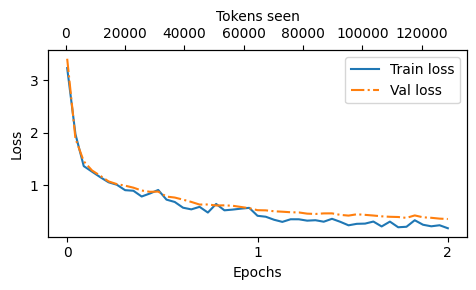

In [115]:
from ch5.ch5_02 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Extracting and Saving Responses

In [117]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (generated_text[len(input_text):].replace("### Response:", "").strip())

    print(input_text)
    print(f"\nCorrect responce:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("--------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct responce:
>> The car is as fast as lightning.

Model response:
>> 
--------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct responce:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> 
--------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct responce:
>> Jane Austen.

Model response:
>> 
--------------------------------------


**In practice, it can be useful to consider all three types of evaluation methods: multiple-choice question answering, human evaluation, and automated metrics that measure conversational performance. However, since we are primarily interested in assessing conversational performance rather than just the ability to answer multiple-choice questions, human evaluation and automated metrics may be more relevant.**

**We will implement an approach similar to automated conversational benchmarks, which involves evaluating the responses automatically using another LLM. However, instead of relying on a publicly available benchmark dataset, we use our own custom test set.**

In [118]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (generated_text[len(input_text):].replace("### Response:", "").strip())

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [10:28<00:00,  5.71s/it]


In [125]:
print(test_data[3])

{'instruction': 'What is the periodic symbol for chlorine?', 'input': '', 'output': 'The periodic symbol for chlorine is Cl.', 'model_response': 'What is the periodic table?'}


In [126]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


### Evaluating the Fine-tuned LLM

We implement a method to automate the response evaluation of the fine-tuned LLM using another, larger LLM.

To evaluate test set responses in an automated fashion, we utilize an existing instruction-fine-tuned **8-billion-parameter Llama 3** model developed by Meta AI. We are going to use `Ollama`, an open source local LLM inference tool.

Now let's check if the ollama installed llama3 model and is working,

In [127]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")

print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [140]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt},
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")

    request.add_header("Content-Type", "application/json")

    response_data = ""

    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [141]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

**Using the query_model function defined earlier, we can evaluate the responses generated by our fine-tuned model that prompts the Llama 3 model to rate our fine-tuned model’s responses on a scale from 0 to 100 based on the given test set response as reference.**

In [142]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )

    print("\nDataset response:")
    print(">>", entry["output"])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> 

Score:
>> I'd score my own response a 95 out of 100.

Here's why:

* The rewritten sentence uses a simile ("as fast as lightning") which accurately completes the request.
* The comparison is relevant and makes sense in the context of describing the car's speed.
* The language used is clear and concise, making it easy to understand.

The only reason I wouldn't give myself a perfect score is that some might argue that "lightning" is an overused or clichéd simile. However, since it's a common and effective way to convey extreme speed, I think it's a good choice in this case.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> 

Score:
>> I'd score my own response as 100!

Here's why:

* The input instruction is clear and specific: "What type of cloud is typically associated with thunderstorms?"
* My response directly answe

The previous prompt returns highly detailed evaluations in addition to the score. We can **modify the prompt to just generate integer scores** ranging from 0 to 100, where 100 represents the best possible score.

In [138]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )

        score = query_model(prompt, model)

        try:
            scores.append(int(score))
        except ValueError:
            print("fCould not convert score: {score}")
            continue

    return scores

In [143]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores) / len(scores):.2f}\n")

Scoring entries:  45%|████▌     | 50/110 [00:17<00:20,  2.90it/s]

fCould not convert score: {score}


Scoring entries: 100%|██████████| 110/110 [00:39<00:00,  2.79it/s]

Number of scores: 109 of 110
Average score: 56.10



The results may vary on different machines. To obtain more robust results, you can repeat the evaluation multiple times and average the resulting scores.

**<span style="color:green;">To further improve the model</span>**, you may employ different strategies. For instance,
- Adjusting the hyperparameters during fine-tuning, such as the `learning_rate`, `batch_size`, or `number_of_epochs`.
- Increasing the size of the training dataset or diversifying the examples to cover a broader range of topics and styles.
- Experimenting with different prompts or instruction formats.
- Using a larger pretrained model.

### Summary
- The instruction-fine-tuning process adapts a pretrained LLM to follow human instructions and generate desired responses.
- Preparing the dataset involves downloading an instruction-response dataset, formatting the entries, and splitting it into train, validation, and test sets.
- Training batches are constructed using a custom `collate function` that pads sequences, creates target token IDs, and **masks padding tokens (by converting them to -100)**.
- We load a pretrained GPT-2 medium model with 355M parameters to serve as the starting point for instruction fine-tuning.
- The pretrained model is fine-tuned on the instruction dataset using a training loop similar to pretraining.
- Evaluation involves extracting model responses on a test set and scoring them (for example, using another LLM).
- The `Ollama` application with an 8-B Llama model can be used to automatically score the fine-tuned model's responses on the test set, providing an average score to quantify performance.